In [2]:
import pandas as pd
import numpy as np

import json
from datetime import datetime
import os

import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

import psycopg2
from fuzzywuzzy import process

from sqlalchemy import create_engine

In [32]:
def top_terms_for_member_styled(df, member_name, n=5):
    if member_name in df['full_name'].values:
        # Extract the row for the member and drop 'full_name' column
        member_row = df[df['full_name'] == member_name].drop(['full_name'], axis=1).squeeze()
        # Ensure member_row is a Series and get the top n terms
        top_terms = member_row.nlargest(n)
        # Convert top terms to DataFrame for styling
        top_terms_df = pd.DataFrame(top_terms).reset_index()
        top_terms_df.columns = ['Term', 'Score']
        
        # Apply styling
        styled_df = top_terms_df.style.set_table_styles(
            [{
                'selector': 'th',
                'props': [('font-size', '12pt'), ('text-align', 'center')]
            },
            {
                'selector': 'td',
                'props': [('font-size', '12pt'), ('text-align', 'center')]
            }]
        ).set_properties(**{
            'background-color': 'lavender',
            'color': 'black',
            'border-color': 'darkgray'
        }).applymap(
            lambda x: f'color: {"darkred" if isinstance(x, float) else "black"}'
        ).set_caption(f"Top {n} Terms for {member_name}")

        return styled_df
    else:
        return f"No data for individual: {member_name}"

In [46]:
def get_top_n_terms(df, n=5):
    df_t = df.T
    top_terms = {}
    for faction in df_t.columns:
        top_terms[faction] = df_t[faction].nlargest(n).index.tolist()
    return pd.DataFrame(top_terms)

In [3]:
council_members = [
    'SandraForNY1', 'LincolnRestler', 'BobHoldenNYC', 'OswaldFeliz', 'AdrienneCD28',
    'KalmanYegerNYC', 'DianaAyalaNYC', 'mvelaznyc', 'KevinCRiley', 'CMMercedesCD46',
    'CMCarlinaRivera', 'Lynn4NYC', 'juliej_won', 'PiSanchezNYC', 'GaleBrewerNYC',
    'crystalrhudson', 'voteshekar', 'ChrisMarteNYC', 'NYCCouncil38', 'DarleneMealy55',
    'Salamancajr80', 'AriKagan47', 'OsseChi', 'KamillahMHanks', 'CarlinaRivera',
    'AmandaFariasNYC', 'KeithPowersNYC', 'CMDarleneMealy', 'ShahanaFromBK',
    'InnaVernikov', 'Powers4Queens', 'KalmanYeger', 'FranciscoMoyaNY', 'JimGennaro',
    'alexaforcouncil', 'CMNantashaW', 'JoeBorelliNYC', 'CnDelarosa', 'JustinBrannan',
    'EricDinowitz', 'ShaunAbreu', 'DarleneMealy', 'JulieMenin', 'ebottcher',
    'DMCarr', 'JoannAriola32', 'galeabrewer', 'FarahNLouis',
    'CMShekarK', 'CMRitaJoseph', 'CouncilwomanKrj', 'CMvpaladino', 'CMPiSanchez',
    'CMJenGutierrez', 'cmmvelaz', 'CMbarron2', 'CMSandyNurse', 'CMBrooksPowers',
    'A_StevensD16', 'CMShaunAbreu', 'CMLindaLee', 'CMSandraUng', 'CMCrystalHudson',
    'CMRestler', 'CMChiOsse', 'CMAriKagan47', 'CMJulieWon', 'CabanD22', 'CMDMCarr',
    'CMSalamancaJr', 'CMKevinCRiley', 'CMAmandaFarias', 'EricDinowitzNYC',
    'CMFranciscoMoya', 'NYCCouncilAyala', 'AdrienneToYou', 'NYCSpeakerAdams',
    'CMShahanaHanif', 'VickieforNYC', 'LindaLeeforNYC', 'JenGutierrezNYC',
    'CarmenForNYC', 'SandyforCouncil', 'RitaJosephNYC', 'CMFarahLouis', 'CMBobHoldenNYC',
    'althea4theBX', 'nycpa', 'tiffany_caban'
]

dsa_oponents = ["evie4us","YuLinCD38"]
dsa_losers = ["jaslinforqueens","mike4brooklyn","brandonwestnyc","BxOrganizer"]

In [58]:
name_username = pd.read_csv('../data/name_username.csv')
tweet_df = pd.read_csv('../data/tweet_df.csv')
cop_vader_bert = pd.read_csv('../data/cops_vader_bert.csv')

tfidf_df_rf = pd.read_csv('../data/rf_tfidf_df.csv', index_col=0)
tfidf_df_rf_pca = pd.read_csv('../data/rf_pca_tfidf_df.csv', index_col=0)
housing_tf_df = pd.read_csv('../data/housing_tfidf_df.csv', index_col=0)

In [5]:
council_members_only = tweet_df[tweet_df['username'].isin(council_members)]
tweets_per_name = council_members_only.groupby('full_name').size().reset_index(name='tweets_count')

In [6]:
tweets_per_name.columns = ['Council Member', 'Number of Tweets']

styled_df = tweets_per_name.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [
            ('background-color', '#007bff'),
            ('color', 'white'),
            ('font-family', 'Arial'),
            ('text-align', 'center')
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('text-align', 'center'),
            ('font-family', 'Arial')
        ]
    }]
).set_properties(**{
    'background-color': 'lavender',
    'color': 'black'
}).set_caption("Tweets per Member")

# City Council Twitter Data

This twitter dataset is composed of 145,313 tweets beginning in January of 2021 aand ending in December of 2023. Of these, 141,807 were authored by members of the 2022-2023 City Council term, the other 3,506 were written by five unsucessful city council candidates important for analysis, two who lost to DSA members and three DSA members who lost their elections. Tweets by campagin losers range from January of 2021 throgh hte election in June of that year. Below is a sample of what work can be done with this dataset. At the time of writing, March 2024, more tweets can be easily acessed, but this si liable to change as Twitter (X) updates its terms of service. 

Here is a list of the number of tweets per council member. The mean number of tweets per user in the dataset is 2,727, with a median of 2,535. Some members did not tweet much, which means I will have to lean harder on other methods to cluster them. When they are clustered, other users tweets in their cluster will speak for them, which could cause issues in interpretation. I do not intend to focus explicitly on the election of any of the members who do not tweet much. 

In [7]:
styled_df

,Council Member,Number of Tweets
0,Adrienne E. Adams,3083
1,Alexa Avilés,2214
2,Althea V. Stevens,1756
3,Amanda Farías,2550
4,Ari Kagan,3922
5,Carlina Rivera,3281
6,Carmen N. De La Rosa,2375
7,Charles Barron,49
8,Chi A. Ossé,677
9,Christopher Marte,195


### Analysis 

This data can be put to many uses. Below is a TF-IDF, term frequency - inverse document frequency, analysis which examines the terms that makes each council members twitter feed unique. 

For example here is DSA endorsed Tiffany Caban's top 10 terms:

In [8]:
tfidf_df = pd.read_csv('../data/member_tfidf_df.csv')

In [34]:
top_terms_for_member_styled(tfidf_df, 'Tiffany Cabán', 10)

,Term,Score
0,astoria,0.278914
1,safety,0.190188
2,violence,0.144664
3,health,0.138170
4,workers,0.132206
5,care,0.113303
6,fight,0.112292
7,housing,0.107355
8,services,0.106222
9,rikers,0.102111


And at the other end of the ideological spectrum, the top 10 terms for Vikcy Paladino:

In [33]:
top_terms_for_member_styled(tfidf_df, 'Vickie Paladino', 10)

,Term,Score
0,whitestone,0.228050
1,school,0.190928
2,bayside,0.159030
3,point,0.139612
4,college,0.133680
5,veterans,0.128384
6,students,0.122681
7,center,0.116994
8,douglaston,0.116449
9,bowne,0.103216


### Top Terms by Council Faction 

Another way to slice this data is to examine top terms by ideological faction. This is a complicated process with a lot of subjective input, but for the sake of example here I based the clustering off of Michael Lange's catagorization of New York City politicians. Lange classifies roughly half the council members in his writing on the subject. I used his partial classification, in conjunction with council voting history, as a basis for a supervised machine learning approach to classification. The table below is the result of that approach. 

In [37]:
faction_compare = pd.read_csv('../data/faction_compare.csv')

In [44]:
faction_compare.columns = ['Council Member', 'Lange Faction','Random Forest Prediction','K-Near Neighbors Prediction','Random Forest w/PCA Prediction']
faction_compare.loc[faction_compare['Lange Faction'].isnull(), 'Lange Faction'] = "Not Specified"

faction_table_df = faction_compare.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [
            ('background-color', '#007bff'),
            ('color', 'white'),
            ('font-family', 'Georgia'),
            ('text-align', 'center')
        ]
    },
    {
        'selector': 'td',
        'props': [
            ('text-align', 'center'),
            ('font-family', 'Georgia')
        ]
    }]
).set_properties(**{
    'background-color': 'lavender',
    'color': 'black'
}).set_caption("Tweets per Member")

In [45]:
faction_table_df

,Council Member,Lange Faction,Random Forest Prediction,K-Near Neighbors Prediction,Random Forest w/PCA Prediction
0,Adrienne E. Adams,County Aligned Moderates,County Aligned Moderates,County Aligned Moderates,County Aligned Moderates
1,Alexa Avilés,DSA,DSA,DSA,DSA
2,Althea V. Stevens,Not Specified,Affluent Liberals,Affluent Liberals,Hybrid Progressives
3,Amanda Farías,Not Specified,Affluent Liberals,Affluent Liberals,Affluent Liberals
4,Ari Kagan,Old and New Republicans,Old and New Republicans,Old and New Republicans,Old and New Republicans
5,Carlina Rivera,Hybrid Progressives,Hybrid Progressives,Hybrid Progressives,Hybrid Progressives
6,Carmen N. De La Rosa,Not Specified,Affluent Liberals,Affluent Liberals,Affluent Liberals
7,Charles Barron,Not Specified,DSA,Alphabet Left,Hybrid Progressives
8,Chi A. Ossé,Not Specified,DSA,DSA,Alphabet Left
9,Christopher Marte,Not Specified,Affluent Liberals,Affluent Liberals,Affluent Liberals


Now ideological faction can be treated as a "document" and the top terms for each faction can be determined.

In [54]:
term_table = get_top_n_terms(tfidf_df_rf, 10)
styled_term_table = term_table.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#606060'), ('color', 'white')]},  # Header styling
    {'selector': 'td', 'props': [('text-align', 'center')]}  # Cell text alignment
]).set_properties(**{
    'background-color': '#f4f4f4',  # Cell background color
    'color': '#000',  # Cell text color
    'border-color': 'white'  # Border color
})

In [55]:
styled_term_table

,Affluent Liberals,Alphabet Left,County Aligned Moderates,DSA,Hybrid Progressives,Old and New Republicans
0,school,school,communities,workers,workers,school
1,housing,communities,women,housing,park,park
2,health,students,health,park,health,safety
3,park,housing,housing,safety,housing,residents
4,communities,care,black,fight,communities,southern
5,families,workers,safety,sunset,women,students
6,workers,women,southeastqueens,justice,free,nypd
7,free,park,families,health,families,life
8,women,fight,violence,communities,learn,police
9,students,services,workers,care,hearing,nycmayor


In [56]:
term_table = get_top_n_terms(tfidf_df_rf_pca, 10)
styled_term_table = term_table.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#606060'), ('color', 'white')]},  # Header styling
    {'selector': 'td', 'props': [('text-align', 'center')]}  # Cell text alignment
]).set_properties(**{
    'background-color': '#f4f4f4',  # Cell background color
    'color': '#000',  # Cell text color
    'border-color': 'white'  # Border color
})

In [57]:
styled_term_table

,Affluent Liberals,Alphabet Left,County Aligned Moderates,DSA,Hybrid Progressives,Old and New Republicans
0,school,housing,communities,workers,park,school
1,health,communities,women,housing,workers,park
2,free,fight,health,park,women,safety
3,families,park,housing,safety,health,residents
4,park,workers,black,fight,communities,students
5,students,school,safety,sunset,housing,nypd
6,women,care,southeastqueens,justice,families,life
7,housing,justice,families,health,free,police
8,workers,health,violence,care,learn,nycmayor
9,communities,free,workers,communities,fight,free


Housing is obviously a common issues to every faction, which is unsurprising. We assume these factions are talking about housing in a different way and offering diferent solutions. To test this we can pull only tweets that mention housing and see how the terms vary.

In [59]:
term_table = get_top_n_terms(housing_tf_df, 10)
styled_term_table = term_table.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#606060'), ('color', 'white')]},  # Header styling
    {'selector': 'td', 'props': [('text-align', 'center')]}  # Cell text alignment
]).set_properties(**{
    'background-color': '#f4f4f4',  # Cell background color
    'color': '#000',  # Cell text color
    'border-color': 'white'  # Border color
})

In [60]:
styled_term_table

,Affluent Liberals,Alphabet Left,County Aligned Moderates,DSA,Hybrid Progressives,Old and New Republicans
0,housing,housing,housing,housing,housing,parents
1,affordable,affordable,affordable,rent,affordable,housing
2,parents,rent,crisis,parents,tenants,school
3,rent,parents,fair,fight,rent,different
4,currently,crisis,address,nycha,parents,current
5,crisis,tenants,rent,education,nychousing,kids
6,different,fight,framework,justice,different,students
7,school,school,agenda,schools,rights,children
8,current,justice,parents,health,crisis,currently
9,students,schools,safety,affordable,justice,migrants


We see the DSA discussing rent, we might assume placing the housing burden on high rents rather than supply constraints or property tax, as well as the word 'fight.' They are also the only group to include NYCHA. The alphabet left, closest to the DSA ideologically, also uses fight and rent, but no mention of public housing. In the Republican faction we see several words relating to schools and zoing, indicating a disuccion of school zones rather than affordability more genearlly. We also see a discussion of migrants, notable as the wave of migrants became a ssalient political divide relatively late in the dataset's history. There is no mention of rent or afordability. 

There is a lot more possibility with this data, both as a group and by analysis of individual council members. As the clustering becomes more accurate the results should be more informative. 

### Sentiment Analysis

Another possibility with these tweets is sentiment analysis. There are many established appraoches to sentiment analysis with social media data, and many directions to go with all of the tweets available here.

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
cop_tweets = cop_vader_bert.copy()

In [65]:
cop_tweets = cop_tweets.merge(name_username, on='username')

One possible application is to pull out all tweets on a certain topic and look at how different groups discuss these tweets, or to look at how the sentiment towards the topic have shifted over time. Below I have pulled every tweet from the dataset that mentions "police", "cops", or "nypd." I have then run a few example analyses. 

The two forms of sentiment analysis I have run are VADER (Valence Aware Dictionary and sEntiment Reasoner), a commonly used sentiment analysis library trained for social media, and BERT Tweet, a sentiment analysis tool built on BERT (Bidirectional Encoder Representations from Transformers), a transformer based deep learning approach developeed by Google capable of understing more nuance in English text. Both assign "Positive," "Negative," and "Neutral" to each tweet. Vader also assignes a numeric score ranging from -1 to 1 to describe the sentiment and BERT assigns a confiedence score to its assesment.

Below is a chart comparing the classification of BERT and VADER. The models agree on 3,358 tweets and disagree on 2,167 tweets. On only 605 tweets were the sentiment scores opposite. 

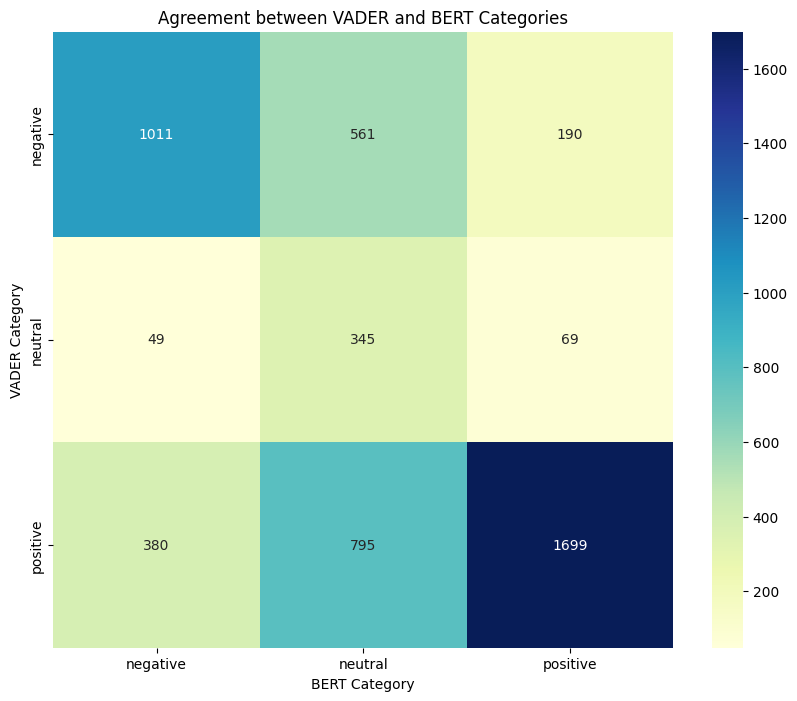

In [93]:
cop_tweets['agreement'] = cop_tweets['vader_sentiment_category'] == cop_tweets['bert_sentiment_category']
agreement_table = pd.crosstab(cop_tweets['vader_sentiment_category'],  cop_tweets['bert_sentiment_category'])

plt.figure(figsize=(10, 8))
sns.heatmap(agreement_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Agreement between VADER and BERT Categories')
plt.ylabel('VADER Category')
plt.xlabel('BERT Category')
plt.show()

There are some definite problems, as a quick review of tweet classification makes clear. For example Crystal Hudson's tweet "So thankful for your leadership\n\nRepealing the WalkingWhileTrans ban is a win for Marsha Sylvia Layleen and all of our trans sisters who have been harassed and violated by the police for simply existing in public" was correclty marked as negative by VADER but classified as positive by BERT. A tweet by Carlina Rivera on sexual misconduct by the NYPD was reported as positive by VADER and neutral by BERT, presumably because she was lauding the acctiosn of the Civilian Complaint Review Board for its actions. I will continue to tweek these models, though it may turn out that a supervised model in which I manually classify some tweets and teach the model to seek out others like them may be more benificial. 

We can track the sentiment of the tweets that use these words over time. There are small spikes in the sentiment of police tweets in July of 2021, 2022, and 2023. Perhaps council members are tweeting about more summer public events in which the police play a role, or perhaps they are responding to a summer uptick in crime. Once the sentiment model is better tuned I can begin a more granular analysis of these shfit. 

In [94]:
cop_tweets['date'] = pd.to_datetime(cop_tweets['date'])
df = cop_tweets.set_index('date')
monthly_scores = df['vader_sentiment_score'].resample('M').mean()

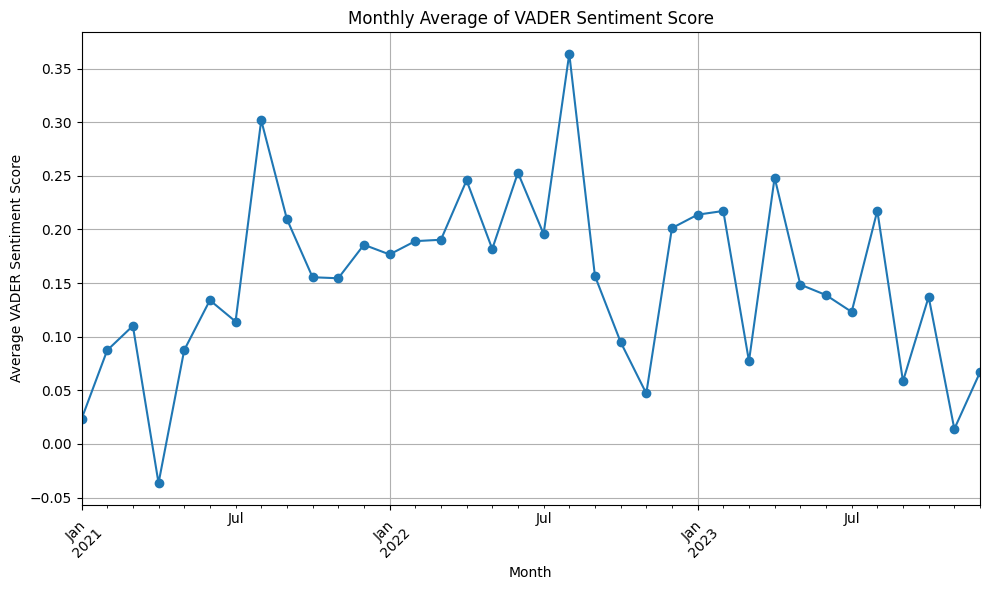

In [95]:
plt.figure(figsize=(10, 6))
monthly_scores.plot(marker='o', linestyle='-')
plt.title('Monthly Average of VADER Sentiment Score')
plt.xlabel('Month')
plt.ylabel('Average VADER Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [99]:
cop_tweets = cop_tweets.merge(faction_compare, left_on='full_name',right_on='Council Member')

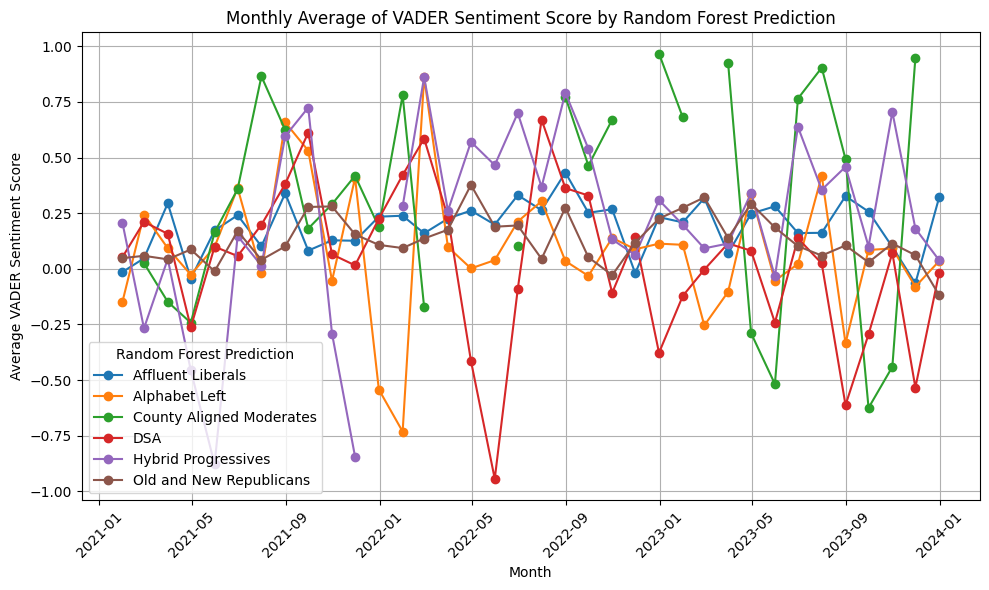

In [100]:
cop_tweets['date'] = pd.to_datetime(cop_tweets['date'])
df = cop_tweets.set_index('date')
grouped = df.groupby('Random Forest Prediction').resample('M')['vader_sentiment_score'].mean()

# Plot
plt.figure(figsize=(10, 6))
for prediction, group in grouped.groupby(level=0):
    plt.plot(group.index.get_level_values(1), group.values, marker='o', linestyle='-', label=prediction)

plt.title('Monthly Average of VADER Sentiment Score by Random Forest Prediction')
plt.xlabel('Month')
plt.ylabel('Average VADER Sentiment Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Random Forest Prediction')
plt.tight_layout()
plt.show()